In [546]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
% matplotlib inline
% load_ext autoreload
% autoreload 2

sns.set(style="darkgrid")

UsageError: Line magic function `%` not found.


In [547]:
from sklearn.metrics import mean_squared_error


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [548]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

In [549]:
y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

print(X.shape)
X.head()

(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [550]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

In [551]:
#Deleting outliers
ids = X_train[(X_train['GrLivArea']>4000) & (y_train<np.log1p(300000))].index
print(ids)
X_train = X_train.drop(ids)
y_train = y_train.drop(ids)

Int64Index([1298], dtype='int64')


In [552]:
transformer = DataTransformer(StandardScaler())

In [553]:
transformer.nums_to_cats(X_train)
transformer.nums_to_cats(X_test)

transformer.fillna(X_train)
transformer.fillna(X_test)

cats_to_drop = ["Utilities"]
X_train = X_train.drop(cats_to_drop, axis=1)
X_test = X_test.drop(cats_to_drop, axis=1)

num_candidates = list(X_train.dtypes[X_train.dtypes != "object"].index.values)
cat_candidates = list(X_train.dtypes[X_train.dtypes == "object"].index.values)

In [554]:
#n_cols = X_train.select_dtypes([np.number]).columns

transformer.imputer_fit(X_train[num_candidates])

X_train[num_candidates] = transformer.imputer_transform(X_train[num_candidates])
X_test[num_candidates] = transformer.imputer_transform(X_test[num_candidates])

transformer.scaler_fit(X_train[num_candidates])

X_train[num_candidates] = transformer.scaler_transform(X_train[num_candidates])
X_test[num_candidates] = transformer.scaler_transform(X_test[num_candidates])

In [555]:
X_train.isnull().sum().sum()
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1079,20,RL,-0.245190,-0.186572,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.26282,-0.064941,None,None,None,-0.082069,4,-0.599678,WD,Normal
389,60,RL,1.177348,0.231219,Pave,None,Reg,Lvl,Inside,Gtl,...,-0.26282,-0.064941,None,None,None,-0.082069,8,0.154443,New,Partial
1349,70,RM,-0.933514,-0.584711,Pave,Pave,Reg,Lvl,Inside,Gtl,...,-0.26282,-0.064941,None,None,None,-0.082069,12,0.154443,WD,Normal
1093,20,RL,0.030140,-0.135182,Pave,None,Reg,Lvl,Corner,Gtl,...,-0.26282,-0.064941,None,MnPrv,None,-0.082069,10,-1.353799,WD,Normal
740,70,RM,-0.474631,-0.093391,Pave,Grvl,Reg,Lvl,Inside,Gtl,...,-0.26282,-0.064941,None,GdPrv,None,-0.082069,5,-0.599678,WD,Abnorml


In [556]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]

In [453]:

train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostRegressor(learning_rate=0.01, iterations=4000)
model.fit(train_pool, eval_set=dev_pool, early_stopping_rounds=20, verbose=0, plot=False)

In [454]:
predictions = model.predict(X_test)
print("RMSLE: " + str(rmsle(predictions, y_test)))

RMSLE: 0.14746944991639852


In [557]:
def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')


In [558]:
to_categorical(X_train)
to_categorical(X_test)

In [559]:
import lightgbm as lgb

clf = lgb.LGBMRegressor(objective='regression',
                        num_leaves=4,
                        learning_rate=0.01,
                        n_estimators=5000,
                        max_bin=200,
                        bagging_fraction=0.75,
                        bagging_freq=5,
                        bagging_seed=7,
                        feature_fraction=0.2,
                        feature_fraction_seed=7,
                        verbose=-1,)

fit_params = {"early_stopping_rounds": 20,
              "eval_metric": 'rmse',
              "eval_set": [(X_test, y_test)],
              'verbose': -1,
              #'categorical_feature': cat_features
              }
clf.fit(X_train, y_train, **fit_params)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, learning_rate=0.01,
              max_bin=200, n_estimators=5000, num_leaves=4,
              objective='regression', verbose=-1)

In [560]:
predictions = clf.predict(X_test)
print("RMSLE: " + str(rmsle(predictions, y_test)))

RMSLE: 0.1512056009545702


In [561]:
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone
from hyperopt import fmin, tpe, hp, anneal, Trials

folds = 4
shuffle = True

random_state = 42

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves'])}

    clf = lgb.LGBMRegressor(random_state=random_state, **params)

    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)

        prediction = clf_fold.predict(X_test_fold)
        loss = rmsle(prediction, y_test_fold)
        loss_list.append(loss)

    score = np.mean(loss_list)

    #print("{:.3f} params {}".format(score, params))
    return score

In [562]:
space={'n_estimators': hp.quniform('n_estimators', 100, 10000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
       'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
       }
trials = Trials()

best=fmin(fn=objective, # function to optimize
          space=space,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate = np.random.default_rng(random_state) # fixing random state for the reproducibility
          )

print("best {}".format(best))

100%|██████████| 100/100 [01:27<00:00,  1.15trial/s, best loss: 0.12257562991159925]
best {'learning_rate': 0.04449286787638083, 'max_depth': 7.0, 'n_estimators': 8245.0, 'num_leaves': 5.0}


In [563]:
lbg_model = lgb.LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']), learning_rate=best['learning_rate'], num_leaves = int(best['num_leaves']))
lbg_model.fit(X_train, y_train, **fit_params)

predictions = lbg_model.predict(X_test)
print("RMSLE: " + str(rmsle(predictions, y_test)))

RMSLE: 0.14562023288528725


### Full dataset & submit

In [564]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

ids = X[(X['GrLivArea']>4000) & (y<np.log1p(300000))].index
X = X.drop(ids)
y = y.drop(ids)

transformer = DataTransformer(StandardScaler())
transformer.nums_to_cats(X)

transformer.fillna(X)

cats_to_drop = ["Utilities"]
X = X.drop(cats_to_drop, axis=1)

num_candidates = list(X.dtypes[X.dtypes != "object"].index.values)
cat_candidates = list(X.dtypes[X.dtypes == "object"].index.values)
#n_cols = X_train.select_dtypes([np.number]).columns

transformer.imputer_fit(X[num_candidates])

X[num_candidates] = transformer.imputer_transform(X[num_candidates])

transformer.scaler_fit(X[num_candidates])

X[num_candidates] = transformer.scaler_transform(X[num_candidates])

In [565]:
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

In [566]:
transformer.nums_to_cats(validation)

transformer.fillna(validation)

cats_to_drop = ["Utilities"]
validation = validation.drop(cats_to_drop, axis=1)

validation[num_candidates] = transformer.imputer_transform(validation[num_candidates])

validation[num_candidates] = transformer.scaler_transform(validation[num_candidates])

In [567]:
to_categorical(X)
to_categorical(validation)

In [568]:
lbg_model = lgb.LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']), learning_rate=best['learning_rate'], num_leaves = int(best['num_leaves']))
lbg_model.fit(X, y, **fit_params)

predictions = lbg_model.predict(X)
print("RMSLE: " + str(rmsle(predictions, y)))

RMSLE: 0.0312804775790715


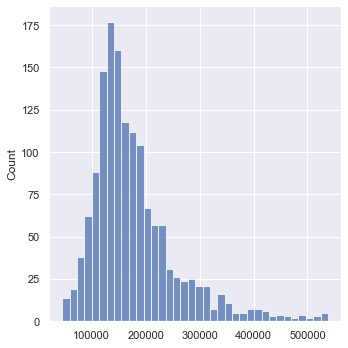

In [583]:
submission = lbg_model.predict(validation)
sns.displot( np.expm1(submission))

In [584]:
d = {'Id': val_ids.to_numpy(), 'SalePrice':  np.expm1(submission)}
df = pd.DataFrame(data=d)
df

,Id,SalePrice
0,1461,125285.018935
1,1462,165427.401828
2,1463,187052.347420
3,1464,192157.247202
4,1465,192938.732801
...,...,...
1454,2915,77679.378796
1455,2916,81354.296262
1456,2917,165166.866978
1457,2918,115814.844620


In [587]:
df.to_csv('submission.csv', index=False)